## Agent & model classes

`Islander` is an agent with brown or blue eyes. It will try to determine its own eye color at each step.

`IslandModel` implements the Kripke model. At each step the agents are updated and the graph of the updated Kripke model is saved.

In [201]:
import mesa
import copy
import pygraphviz as pgv

from itertools import product
from pathlib import Path


BROWN = "0"
BLUE = "1"
ALL = "2"


class Islander(mesa.Agent):
    """Islander with blue or brown eyes"""

    # Initialize islander with eye color
    def __init__(self, unique_id, model, eye_color):
        super().__init__(unique_id, model)
        self.eye_color = eye_color
        self.alive = True

    # Update knowledge to determine own eye color
    def determine_eye_color(self) -> str | None:
        w_real = self.model.w_real
        w_possible = self.model.g.neighbors(w_real)
        uid = self.unique_id
        if all([w_real[uid] == w[uid] for w in w_possible]):
            return self.eye_color
        
    # Agent step function called by mesa
    def step(self):
        if self.eye_color == BLUE:
            self.alive = (self.determine_eye_color() == None)


class IslandModel(mesa.Model):
    """Keeps track of islanders and Kripke models"""

    # Initialize island grid with islanders
    def __init__(self, n_brown, n_blue, variant):
        self.n_brown = n_brown
        self.n_blue = n_blue
        self.n_agents = n_brown + n_blue
        self.agents = []
        self.w_real = None
        self.w_all = None
        self.variant = variant
        self.g = None
        self.img_path = Path("graphs") / f"{n_brown}x{n_blue}"
        self.img_path.mkdir(exist_ok=True, parents=True)
        self.schedule = mesa.time.SimultaneousActivation(self)
        self.data_alive = mesa.DataCollector({ALL: lambda m: m.get_alive(), 
                                              BROWN: lambda m: m.get_alive_brown(), 
                                              BLUE: lambda m: m.get_alive_blue(),
                                            })
        self.data_alive.collect(self)

        # Create agents
        for i in range(self.n_agents):
            eye_color = BROWN if i < n_brown else BLUE
            a = Islander(i, self, eye_color)
            self.agents.append(a)
            self.schedule.add(a)

        # Create Kripke models
        brown_eyed = [BROWN] * n_brown
        blue_eyed = [BLUE] * n_blue
        self.w_real = ''.join(brown_eyed + blue_eyed)
        w_all = generate_combinations(self.n_agents)
        self.w_all = w_all
        
        # Create model graph
        g = pgv.AGraph(rankdir='LR', ratio='auto')
        g.add_node((self.w_real), style='filled', fillcolor='green')
        for w in self.w_all:
            g.add_node((w),style='filled')
            j = 1
            for eye_color in w:
                if eye_color == BLUE:
                    g.add_edge(w, w[0:j-1] + BROWN + w[j:], label=f'R_{j}', dir='both') 
                j+=1
        
        self.g = g
        self.draw_graph()

    # Number of living agents
    def get_alive(self):
        return sum([1 for a in self.agents if a.alive])

    # Number of living agents with brown eyes
    def get_alive_brown(self):
        return sum([1 for a in self.agents if (a.alive and a.eye_color == BROWN)])

    # Number of living agents with blue eyes
    def get_alive_blue(self):
        return sum([1 for a in self.agents if (a.alive and a.eye_color == BLUE)])
    
    # Update model graph
    def update_graph(self):
        day = self.schedule.time
        for w in self.w_all:
            l_num = 0
            for eye_color in w:
                if eye_color == BLUE:
                    l_num += 1
            if l_num == day:
                if w != self.w_real:
                    self.g.remove_node(w)
    
    # Draw model graph
    def draw_graph(self):
        self.g.draw(self.img_path / f'step_{self.schedule.time:03d}.jpg', prog='dot') 

    # Model step function called by mesa
    def step(self):
        self.schedule.step()
        self.data_alive.collect(self)
        self.update_graph()
        self.draw_graph()


# Create all possible states
def generate_combinations(n_agents):
    options = [BROWN, BLUE]
    return [''.join(p) for p in product(options, repeat=n_agents)]

## Model parameters

Set the number of brown- and blue-eyed islanders and select the "default" or "blind" scenario.

In [202]:
N_BROWN = 3
N_BLUE = 2
VARIANT = "default"

## Create model

In [203]:
model = IslandModel(n_brown=N_BROWN, n_blue=N_BLUE, variant=VARIANT)

## Run model

Once the blue-eyed islanders learn the color of their eyes, they will commit ritual suicide the next day.

In [204]:
# Until all blue-eyed islanders are gone
while model.get_alive_blue():
    model.step()

## Plot results

Show the number of living agents per step.

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})

In [206]:
# Agents alive over time
alive_all = model.data_alive.model_vars[ALL]
alive_brown = model.data_alive.model_vars[BROWN]
alive_blue = model.data_alive.model_vars[BLUE]
# Correct mesa bug which sets all values to 0 at step 0
alive_all[0] = N_BROWN + N_BLUE
alive_brown[0] = N_BROWN
alive_blue[0] = N_BLUE
# x values
steps = range(len(alive_all))

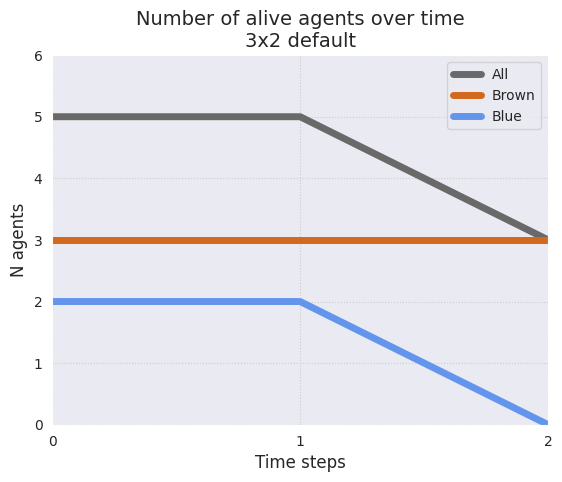

In [216]:
plt.plot(steps, alive_all, label="All", linewidth=5, color="dimgray")
plt.plot(steps, alive_brown, label="Brown", linewidth=5, color="chocolate")
plt.plot(steps, alive_blue, label="Blue", linewidth=5, color="cornflowerblue")
plt.title(f"Number of alive agents over time\n{N_BROWN}x{N_BLUE} {VARIANT}", fontsize=14)
plt.ylabel("N agents", fontsize=12)
plt.xlabel("Time steps", fontsize=12)
plt.xticks(steps)
plt.xlim(0, len(alive_all)-1)
plt.ylim(0, (N_BROWN + N_BLUE + 1))
plt.legend()